<a href="https://colab.research.google.com/github/nidhi-059/Region-captioning-on-images-using-dl/blob/main/Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import Counter
import random
import numpy as np
import re

from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity

Vocab size: 1319
Total training pairs: 183612
Starting training...
Epoch 1/50, Loss: 11.3447, Accuracy: 0.5665
Epoch 2/50, Loss: 4.2919, Accuracy: 0.7205
Epoch 3/50, Loss: 3.1395, Accuracy: 0.7810
Epoch 4/50, Loss: 2.7378, Accuracy: 0.8123
Epoch 5/50, Loss: 2.5403, Accuracy: 0.8291
Epoch 6/50, Loss: 2.4219, Accuracy: 0.8423
Epoch 7/50, Loss: 2.3517, Accuracy: 0.8522
Epoch 8/50, Loss: 2.3078, Accuracy: 0.8586
Epoch 9/50, Loss: 2.2696, Accuracy: 0.8639
Epoch 10/50, Loss: 2.2452, Accuracy: 0.8685
Epoch 11/50, Loss: 2.2218, Accuracy: 0.8744
Epoch 12/50, Loss: 2.2089, Accuracy: 0.8777
Epoch 13/50, Loss: 2.1929, Accuracy: 0.8808
Epoch 14/50, Loss: 2.1779, Accuracy: 0.8854
Epoch 15/50, Loss: 2.1689, Accuracy: 0.8862
Epoch 16/50, Loss: 2.1591, Accuracy: 0.8906
Epoch 17/50, Loss: 2.1490, Accuracy: 0.8917
Epoch 18/50, Loss: 2.1439, Accuracy: 0.8937
Epoch 19/50, Loss: 2.1372, Accuracy: 0.8954
Epoch 20/50, Loss: 2.1319, Accuracy: 0.8971
Epoch 21/50, Loss: 2.1238, Accuracy: 0.8990
Epoch 22/50, Loss

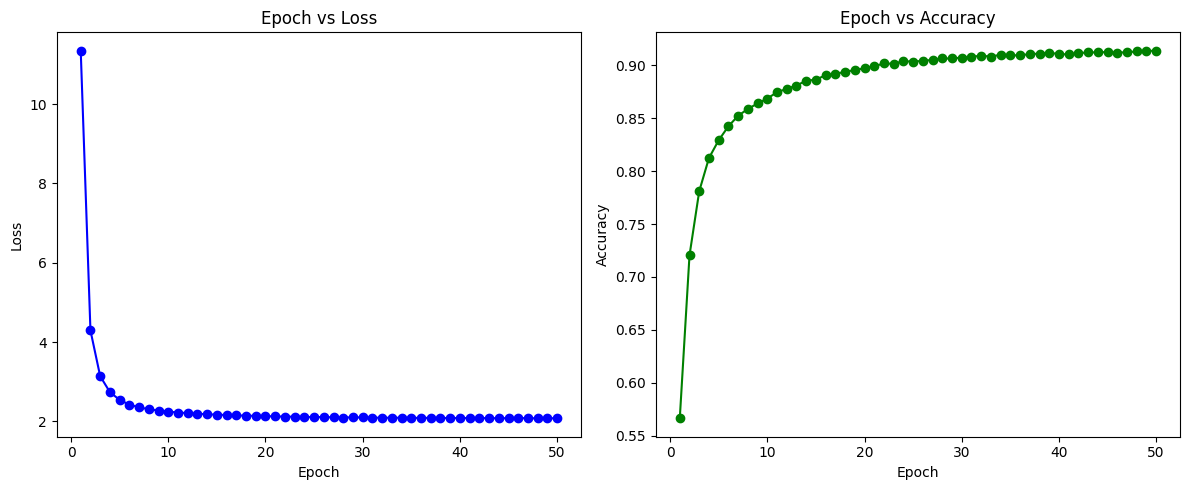

In [ ]:
dataset = load_dataset("imdb", split='train[:1%]')  # 1% subset

#Text preprocessing and tokenization
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)     # Remove punctuation, numbers
    text = text.lower() #smallcase conversion
    tokens = text.split()  #creating tokens
    return tokens

tokenized_corpus = [clean_text(item['text']) for item in dataset]

# Flatten tokens and build vocab
all_words = [word for sentence in tokenized_corpus for word in sentence]
word_freq = Counter(all_words)

# Filter rare words
min_freq = 5
vocab = [word for word, freq in word_freq.items() if freq >= min_freq]
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)

print(f"Vocab size: {vocab_size}")

# Filter corpus to keep only known vocab words
filtered_corpus = []
for sentence in tokenized_corpus:
    filtered_corpus.append([w for w in sentence if w in word2idx])

#Generate skip-gram pairs with window size
def generate_skipgram_pairs(corpus, window_size):
    pairs = []
    for tokens in corpus:
        for i, center in enumerate(tokens):
            start = max(i - window_size, 0)
            end = min(i + window_size + 1, len(tokens))
            for j in range(start, end):
                if i != j:
                    pairs.append((center, tokens[j]))
    return pairs

window_size = 2
pairs = generate_skipgram_pairs(filtered_corpus, window_size=window_size)
print(f"Total training pairs: {len(pairs)}")

#Dataset with negative sampling
class SkipGramNegDataset(Dataset):
    def __init__(self, pairs, word2idx, vocab_size, num_negatives=5):
        self.pairs = pairs
        self.word2idx = word2idx
        self.vocab_size = vocab_size
        self.num_negatives = num_negatives

        # Precompute unigram distribution raised to 3/4th power for negative sampling
        freq_array = np.array([word_freq[w] for w in word2idx.keys()], dtype=np.float32)
        unigram_dist = freq_array / freq_array.sum()
        self.neg_dist = unigram_dist ** 0.75
        self.neg_dist = self.neg_dist / self.neg_dist.sum()


    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center_word, context_word = self.pairs[idx]
        center_idx = self.word2idx[center_word]
        context_idx = self.word2idx[context_word]

        neg_samples = np.random.choice(
            self.vocab_size,
            size=self.num_negatives,
            replace=False,
            p=self.neg_dist
        )

        return center_idx, context_idx, torch.LongTensor(neg_samples)

#Model
class SkipGramNegModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegModel, self).__init__()
        self.center_embed = nn.Embedding(vocab_size, embedding_dim)
        self.context_embed = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, center, pos_context, neg_contexts):
        center_emb = self.center_embed(center)                # (B, D)
        pos_emb = self.context_embed(pos_context)             # (B, D)
        neg_emb = self.context_embed(neg_contexts)            # (B, K, D)

        # Positive score
        pos_score = torch.mul(center_emb, pos_emb).sum(dim=1) # (B)
        pos_loss = F.logsigmoid(pos_score)

        # Negative scores
        neg_score = torch.bmm(neg_emb, center_emb.unsqueeze(2)).squeeze()  # (B, K)
        neg_loss = F.logsigmoid(-neg_score).sum(dim=1)                    # (B)

        loss = -(pos_loss + neg_loss).mean()
        return loss

#Training loop

embedding_dim = 100
batch_size = 512
epochs = 50
lr = 0.01
num_negatives = 5

dataset = SkipGramNegDataset(pairs, word2idx, vocab_size, num_negatives)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkipGramNegModel(vocab_size, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
accuracies = []

print("Starting training...")
for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0

    for center, pos, neg in dataloader:
        center, pos, neg = center.to(device), pos.to(device), neg.to(device)
        optimizer.zero_grad()

        center_emb = model.center_embed(center)                # (B, D)
        pos_emb = model.context_embed(pos)                     # (B, D)
        neg_emb = model.context_embed(neg)                     # (B, K, D)

        # Positive scores
        pos_score = torch.mul(center_emb, pos_emb).sum(dim=1)  # (B)
        pos_loss = F.logsigmoid(pos_score)

        # Negative scores
        neg_score = torch.bmm(neg_emb, center_emb.unsqueeze(2)).squeeze()  # (B, K)
        neg_loss = F.logsigmoid(-neg_score).sum(dim=1)                     # (B)

        loss = -(pos_loss + neg_loss).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy metric: Check if positive score > average negative score
        with torch.no_grad():
            avg_neg_score = neg_score.mean(dim=1)              # (B)
            correct += (pos_score > avg_neg_score).sum().item()
            total += center.size(0)

    epoch_loss = total_loss / len(dataloader)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

#Extract embeddings and find similar words
embeddings = model.center_embed.weight.data.cpu().numpy()

def find_similar_words(word, embeddings, word2idx, idx2word, top_k=10):
    if word not in word2idx:
        print(f"'{word}' not in vocabulary.")
        return []
    idx = word2idx[word]
    query_vec = embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(query_vec, embeddings)[0]
    top_indices = sims.argsort()[-top_k-1:][::-1]  # top_k + self
    top_words = [idx2word[i] for i in top_indices if i != idx][:top_k]
    print(f"Top {top_k} words similar to '{word}':")
    print(top_words)
    return top_words

#Show results for some random words
sample_words = random.sample(list(word2idx.keys()), 5)
for w in sample_words:
    find_similar_words(w, embeddings, word2idx, idx2word)

#Plotting
plt.figure(figsize=(12, 5))

#Epoch vs Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), losses, marker='o', color='blue')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

#Epoch vs Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), accuracies, marker='o', color='green')
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()



In [ ]:
def evaluate_embedding_accuracy(model, word2idx, idx2word, test_words, top_k=5):
    embeddings = model.center_embed.weight.data.cpu().numpy()
    correct = 0

    for word in test_words:
        if word not in word2idx:
            print(f"'{word}' not in vocab, skipping.")
            continue
        idx = word2idx[word]
        vec = embeddings[idx].reshape(1, -1)
        sims = cosine_similarity(vec, embeddings)[0]
        top_indices = sims.argsort()[-top_k-1:][::-1]
        top_words = [idx2word[i] for i in top_indices if i != idx][:top_k]

        print(f"\nWord: '{word}' — Top {top_k} similar: {top_words}")

        # Simple accuracy test: if the word shares a stem or is found in similar context
        if any(word in w or w in word for w in top_words):
            correct += 1

    total = len(test_words)
    print(f"\nSimulated Top-{top_k} Accuracy: {correct}/{total} = {correct / total:.2f}")


In [ ]:
test_words = ['movie', 'good', 'bad', 'love', 'boring']
evaluate_embedding_accuracy(model, word2idx, idx2word, test_words, top_k=5)



Word: 'movie' — Top 5 similar: ['film', 'classics', 'moviebr', 'movies', 'review']

Word: 'good' — Top 5 similar: ['solid', 'waiting', 'excellent', 'fine', 'listed']

Word: 'bad' — Top 5 similar: ['jones', 'slow', 'unbelievable', 'sucks', 'local']

Word: 'love' — Top 5 similar: ['finding', 'satire', 'background', 'whats', 'lucy']

Word: 'boring' — Top 5 similar: ['james', 'fast', 'became', 'brother', 'future']

Simulated Top-5 Accuracy: 1/5 = 0.20


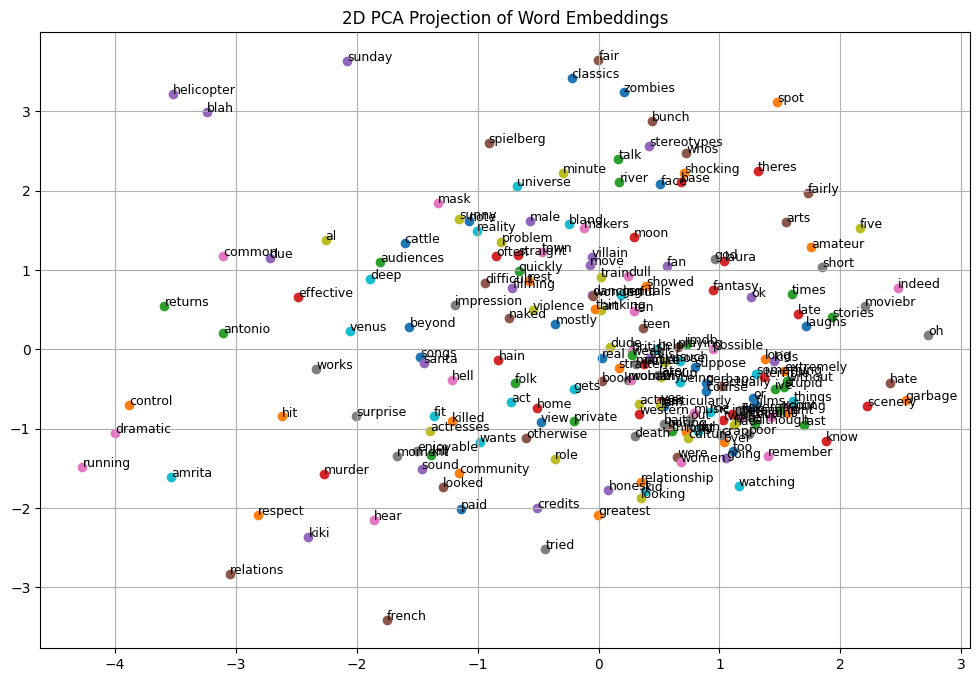

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings_2d(model, word2idx, sample_size=200):
    embeddings = model.center_embed.weight.data.cpu().numpy()
    words = list(word2idx.keys())


    sampled_words = random.sample(words, min(sample_size, len(words)))
    sampled_indices = [word2idx[word] for word in sampled_words]
    sampled_embeddings = embeddings[sampled_indices]

    #Reduce to 2D using PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(sampled_embeddings)

    #Plot
    plt.figure(figsize=(12, 8))
    for i, word in enumerate(sampled_words):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), fontsize=9)
    plt.title("2D PCA Projection of Word Embeddings")
    plt.grid(True)
    plt.show()
plot_embeddings_2d(model, word2idx, sample_size=200)
